### Import Libraries

In [1]:
import numpy as np
import sympy
from sympy import Heaviside
import random
import math
import matplotlib.pyplot as plot

### Downloaded Functions

In [2]:
def generate_trainingdata(m=25):
    return np.array([0,0])+0.25*np.random.randn(m,2)

def f(x, minibatch):
    # loss function sum_{w in training data} f(x,w)
    y=0; count=0
    for w in minibatch:
        z=x-w-1
        y=y+min(24*(z[0]**2+z[1]**2), (z[0]+3)**2+(z[1]+3)**2)   
        count=count+1
    return y/count

### Question a(i): Mini-batch Stochastic Gradient Descent for Constant Step Size, Polyak, RMSProp, Heavy Ball and Adam steps

In [3]:
class Stochastic_Gradient_Descent : 
    
    def __init__(self, starting_point  = [1, 1]) : 
        self.train_data = self.generate_trainingdata()
        self.x1 = starting_point[0]
        self.x2 = starting_point[1]
        self.x1_values = np.array([self.x1])
        self.x2_values = np.array([self.x2])
        self.function_values = np.array([self.f([self.x1, self.x2], self.train_data)])
        self.x_z = self.y_z = self.x_v = self.x_m = self.y_v = self.y_m = self.adam_iteration = 0
        
    def f(self, x, minibatch) : 
        # loss function sum_{w in training data} f(x,w)
        y=0; count=0
        for w in minibatch:
            z=x-w-1
            y=y+min(24*(z[0]**2+z[1]**2), (z[0]+3)**2+(z[1]+3)**2)   
            count=count+1
        return y/count
    
    def generate_trainingdata(self, m=25) : 
        return np.array([0,0])+0.25*np.random.randn(m,2)
    
    def get_derivative_value(self, x1, w1, x2, w2) :
        derivative_x1_value = (-48*w1 + 48*x1 - 48)*Heaviside(-24*(-w1 + x1 - 1)**2 + (-w1 + x1 + 2)**2 - 24*(-w2 + x2 - 1)**2 + (-w2 + x2 + 2)**2) + (-2*w1 + 2*x1 + 4)*Heaviside(24*(-w1 + x1 - 1)**2 - (-w1 + x1 + 2)**2 + 24*(-w2 + x2 - 1)**2 - (-w2 + x2 + 2)**2)
        derivative_x2_value = (-48*w2 + 48*x2 - 48)*Heaviside(-24*(-w1 + x1 - 1)**2 + (-w1 + x1 + 2)**2 - 24*(-w2 + x2 - 1)**2 + (-w2 + x2 + 2)**2) + (-2*w2 + 2*x2 + 4)*Heaviside(24*(-w1 + x1 - 1)**2 - (-w1 + x1 + 2)**2 + 24*(-w2 + x2 - 1)**2 - (-w2 + x2 + 2)**2)
        return derivative_x1_value, derivative_x2_value
    
    def get_batch_derivative(self, x1, x2, sample_batch) : 
        sum_derivative_x1_value = 0
        sum_derivative_x2_value = 0
        
        for w1, w2 in sample_batch : 
            derivative_x1_value, derivative_x2_value = self.get_derivative_value(x1, w1, x2, w2)
            sum_derivative_x1_value += derivative_x1_value
            sum_derivative_x2_value += derivative_x2_value
        
        batch_derivative_x1_value = sum_derivative_x1_value / len(sample_batch)
        batch_derivative_x2_value = sum_derivative_x2_value / len(sample_batch)
        
        return batch_derivative_x1_value, batch_derivative_x2_value
    
    
    def execute_stochastic_gradient_descent(self, gradient_descent_type = 'Constant', alpha = 0.1, beta = 0.9, beta2 = 0.999, batch_size = 10) :
        
        np.random.shuffle(self.train_data)
        for j in range(0, len(self.train_data), batch_size) : 
            
            if (j + batch_size) > len(self.train_data) : 
                continue
            
            if gradient_descent_type == 'Constant Step Size' : 
                self.x1, self.x2 = self.execute_constant_size_gradient_descent(self.train_data[j : (j + batch_size)], alpha)
                
            elif gradient_descent_type == 'Polyak' : 
                self.x1, self.x2 = self.execute_polyak_gradient_descent(self.train_data[j : (j + batch_size)])
            
            elif gradient_descent_type == 'RMSProp':
                self.x1, self.x2 = self.execute_rmsprop_gradient_descent(self.train_data[j : (j + batch_size)], alpha, beta)
                
            elif gradient_descent_type == 'HeavyBall':
                self.x1, self.x2 = self.execute_heavyball_gradient_descent(self.train_data[j : (j + batch_size)], alpha, beta)
            
            elif gradient_descent_type == 'Adam':
                self.x1, self.x2 = self.execute_adam_gradient_descent(self.train_data[j : (j + batch_size)], alpha, beta, beta2)
             
                
        self.x1_values = np.append(self.x1_values, [self.x1], axis = 0)
        self.x2_values = np.append(self.x2_values, [self.x2], axis = 0)
        self.function_values = np.append(self.function_values, [self.f([self.x1, self.x2], self.train_data)])
        
        return self.x1_values, self.x2_values, self.function_values
    
    def execute_constant_size_gradient_descent(self, sample_batch, alpha) : 
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        self.x1 -= alpha * batch_derivative_x1
        self.x2 -= alpha * batch_derivative_x2
        return self.x1, self.x2
    
    def execute_polyak_gradient_descent(self, sample_batch) : 
        epsilon = 1e-8
        numerator = self.f([self.x1, self.x2], sample_batch)
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        denominator = ((batch_derivative_x1) **2 + (batch_derivative_x2) ** 2) + epsilon
        step =  (numerator / denominator) if denominator !=0  else 0
        self.x1 = self.x1 - step * batch_derivative_x1
        self.x2 = self.x2 - step * batch_derivative_x2
        
        return self.x1, self.x2
    
    def execute_rmsprop_gradient_descent(self, sample_batch, alpha, beta) : 
        epsilon = 1e-8
        x_alpha = alpha
        y_alpha = alpha
        x_sum = 0
        y_sum = 0

        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        x_sum = (x_sum * beta) + ((1 - beta) * ((batch_derivative_x1) ** 2))
        y_sum = (y_sum * beta) + ((1 - beta) * ((batch_derivative_x2) ** 2))

        x_alpha = alpha / (math.sqrt(x_sum) + epsilon)
        y_alpha = alpha / (math.sqrt(y_sum) + epsilon)

        self.x1 = self.x1 - (x_alpha * batch_derivative_x1)
        self.x2 = self.x2 - (y_alpha * batch_derivative_x2)


        return self.x1, self.x2
    
    def execute_heavyball_gradient_descent(self, sample_batch, alpha, beta) :
        epsilon = 1e-8
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        self.x_z = (self.x_z * beta) + (alpha * batch_derivative_x1)
        self.y_z = (self.y_z * beta) + (alpha * batch_derivative_x2)

        self.x1 = self.x1 - self.x_z
        self.x2 = self.x2 - self.y_z

        return self.x1, self.x2
    
    def execute_adam_gradient_descent(self, sample_batch, alpha, beta_1, beta_2) : 
        epsilon = 1e-8
        
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)

        self.x_m = (self.x_m * beta_1) + ((1 - beta_1) * batch_derivative_x1)
        self.y_m = (self.y_m * beta_1) + ((1 - beta_1) * batch_derivative_x2)

        self.x_v = (self.x_v * beta_2) + ((1 - beta_2) * ((batch_derivative_x1) ** 2))
        self.y_v = (self.y_v * beta_2) + ((1 - beta_2) * ((batch_derivative_x2) ** 2))

        x_m_hat = self.x_m / (1 - beta_1 ** self.adam_iteration + 1)
        y_m_hat = self.y_m / (1 - beta_1 ** self.adam_iteration + 1)

        x_v_hat = self.x_v / (1 - beta_2 ** self.adam_iteration + 1)               
        y_v_hat = self.y_v / (1 - beta_2 ** self.adam_iteration + 1)

        x_alpha = x_m_hat / (math.sqrt(x_v_hat) + epsilon)
        y_alpha = y_m_hat / (math.sqrt(y_v_hat) + epsilon)

        self.x1 = self.x1 - (x_alpha * alpha)
        self.x2 = self.x2 - (y_alpha * alpha)
        
        self.adam_iteration += 1
    
        return self.x1, self.x2

### Question a(ii):  Plot a wireframe and a contour plot of f for N = T

In [4]:
class Question_a_ii : 
    
    def generate_trainingdata(self, m=25):
        return np.array([0,0])+0.25*np.random.randn(m,2)

    def f(self, x, minibatch):
        # loss function sum_{w in training data} f(x,w)
        y=0; count=0
        for w in minibatch:
            z=x-w-1
            y=y+min(24*(z[0]**2+z[1]**2), (z[0]+3)**2+(z[1]+3)**2)   
            count=count+1
        return y/count
    
    def generate_wirefame_contour_plot(self) : 
        x1 = np.linspace(-8, 4, 200)
        x2 = np.linspace(-8, 4, 200)
        f = []
        training_data = self.generate_trainingdata()
        
        for x1_point in x1 : 
            data_point = []
            for x2_point in x2 : 
                data_point.append(self.f([x1_point, x2_point], training_data))
            f.append(data_point)
        f_x1_x2 = np.array(f)
        X1, X2 = np.meshgrid(x1, x2)
        
        
        plot.figure(figsize=(9, 6), dpi=150)
        ax = plot.axes(projection='3d')     
        ax.contour3D(X1, X2, f_x1_x2, 45)       
        ax.set_xlabel('X1')        
        ax.set_ylabel('X2') 
        ax.set_zlabel('f([X1, X2], training_data)')
        ax.set_title('3-D Contour plot of f([X1, X2], training_data))')
        plot.show()
        
        plot.figure(figsize=(9, 6), dpi=150)
        ax = plot.axes()     
        countour = ax.contour(X1, X2, f_x1_x2)       
        ax.set_xlabel('X1')        
        ax.set_ylabel('X2') 
        ax.clabel(countour)
        ax.set_title('Contour plot of f([X1, X2], training_data))')
        plot.show()
        
        
        ax = plot.figure(figsize=(9, 6), dpi=150).add_subplot(111, projection='3d')
        ax.plot_wireframe(X1, X2, f_x1_x2)
        ax.set_xlabel('X1')        
        ax.set_ylabel('X2') 
        ax.set_zlabel('f([X1, X2], training_data)')
        ax.set_title('3-D Wireframe plot of f([X1, X2], training_data))')
        plot.show()

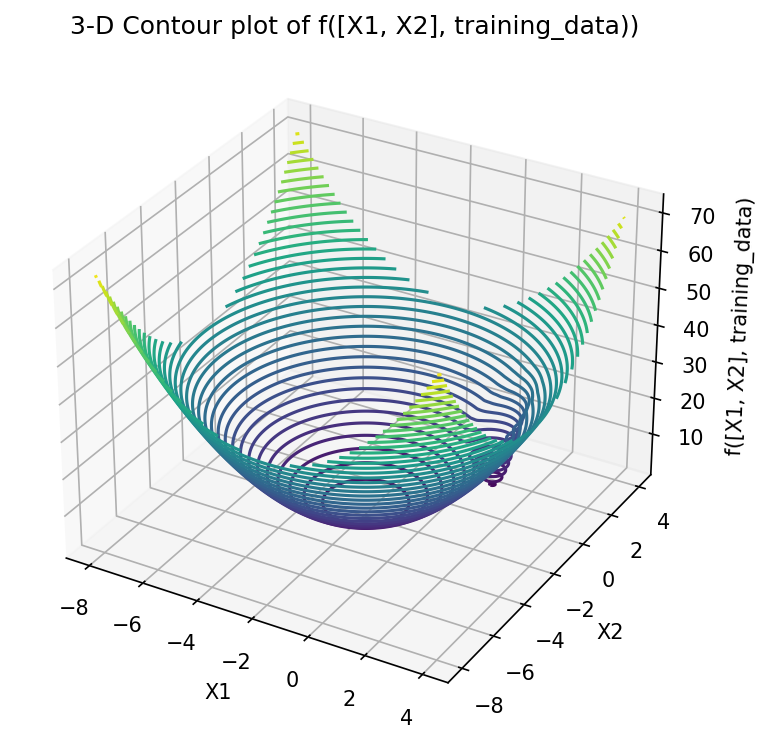

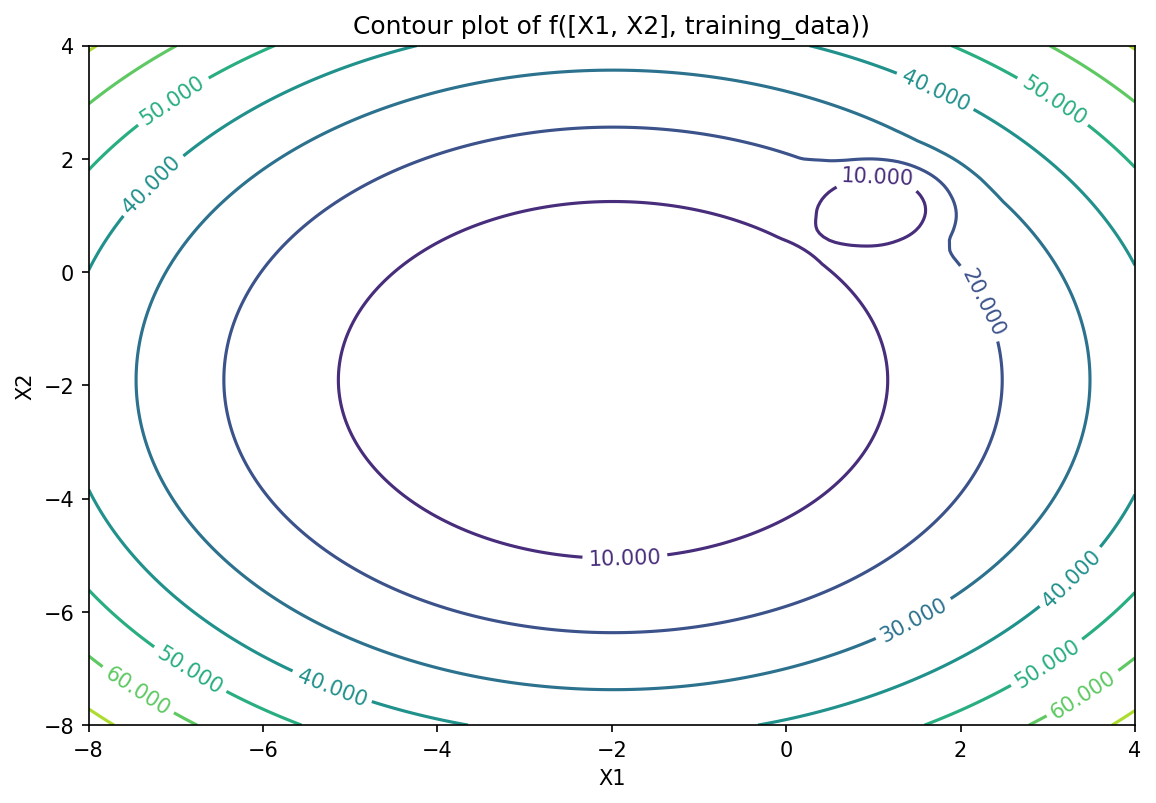

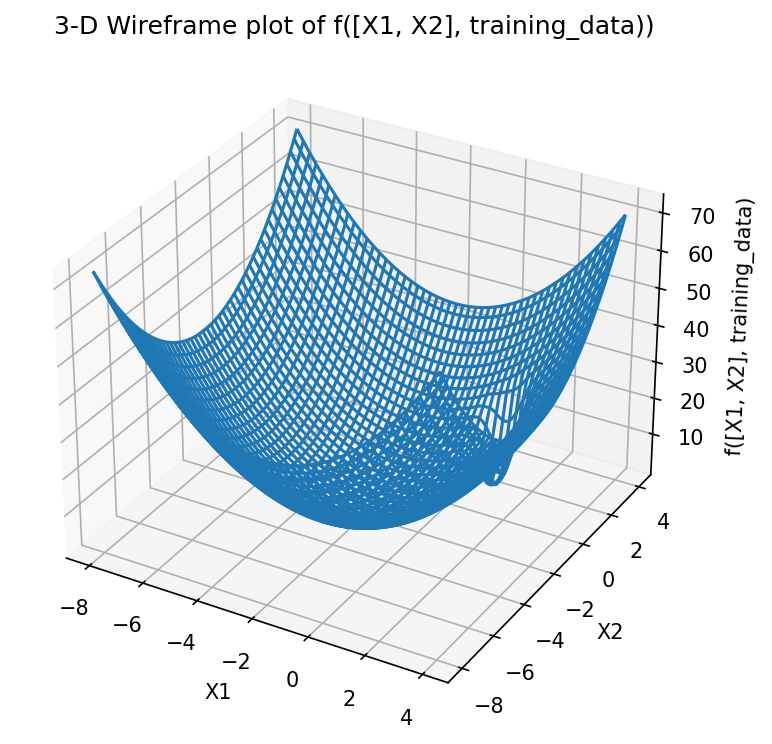

In [5]:
q_a_ii = Question_a_ii()
q_a_ii.generate_wirefame_contour_plot()

### Question a(iii): Get Sympy Derivative for the downloaded function

In [6]:
class Question_a_iii : 
    
    def get_equation_notation(self) :
        x1, x2, w1, w2 = sympy.symbols('x1 x2 w1 w2', real = True)
        equation = sympy.Min(24 * ((x1 - w1 - 1) ** 2 + (x2 - w2 - 1) ** 2), ((x1 - w1 - 1) + 3) ** 2 + ((x2 - w2 - 1) + 3) ** 2) 
        return equation
   
    def get_sympy_derivative_notation_x1(self) : 
        x1 = sympy.symbols('x1', real = True)
        derivative_x1 = sympy.diff(self.get_equation_notation(), x1)
        return derivative_x1
        
    def get_sympy_derivative_notation_x2(self) : 
        x2 = sympy.symbols('x2', real = True)
        derivative_x2 = sympy.diff(self.get_equation_notation(), x2)
        return derivative_x2

In [7]:
q_a_iii = Question_a_iii()

f = q_a_iii.get_equation_notation()
print(f"Equation for Function f is: {f}")

Equation for Function f is: Min(24*(-w1 + x1 - 1)**2 + 24*(-w2 + x2 - 1)**2, (-w1 + x1 + 2)**2 + (-w2 + x2 + 2)**2)


In [8]:
derivative_df_dx1 = q_a_iii.get_sympy_derivative_notation_x1()
print(f"Derivative for f = {f} with respect to x1 is: {derivative_df_dx1}")

Derivative for f = Min(24*(-w1 + x1 - 1)**2 + 24*(-w2 + x2 - 1)**2, (-w1 + x1 + 2)**2 + (-w2 + x2 + 2)**2) with respect to x1 is: (-48*w1 + 48*x1 - 48)*Heaviside(-24*(-w1 + x1 - 1)**2 + (-w1 + x1 + 2)**2 - 24*(-w2 + x2 - 1)**2 + (-w2 + x2 + 2)**2) + (-2*w1 + 2*x1 + 4)*Heaviside(24*(-w1 + x1 - 1)**2 - (-w1 + x1 + 2)**2 + 24*(-w2 + x2 - 1)**2 - (-w2 + x2 + 2)**2)


In [9]:
derivative_df_dx2 = q_a_iii.get_sympy_derivative_notation_x2()
print(f"Derivative for f = {f} with respect to x1 is: {derivative_df_dx2}")

Derivative for f = Min(24*(-w1 + x1 - 1)**2 + 24*(-w2 + x2 - 1)**2, (-w1 + x1 + 2)**2 + (-w2 + x2 + 2)**2) with respect to x1 is: (-48*w2 + 48*x2 - 48)*Heaviside(-24*(-w1 + x1 - 1)**2 + (-w1 + x1 + 2)**2 - 24*(-w2 + x2 - 1)**2 + (-w2 + x2 + 2)**2) + (-2*w2 + 2*x2 + 4)*Heaviside(24*(-w1 + x1 - 1)**2 - (-w1 + x1 + 2)**2 + 24*(-w2 + x2 - 1)**2 - (-w2 + x2 + 2)**2)
